## Prepare GPU, access to Google Drive and Hugging Face ##

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Oct  4 12:54:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Replace 'path_to_your_directory' with the actual path where you added the shortcut
path = '/content/drive/My Drive/Lobbymap_QLoRA'
files = os.listdir(path)
print(files)


Mounted at /content/drive
['company_sector_region.csv', 'test.jsonl', 'train.jsonl', 'valid.jsonl', 'QLoRA.ipynb', 'Copy of QLoRA.ipynb', 'LoRA.ipynb', 'InforExtraction_2024_09_29.ipynb', 'InforExtraction_training.ipynb', 'InforExtraction.ipynb', 'evaluation_results.txt', 'InforExtractionPage.ipynb']


In [ ]:
!pip install transformers datasets pandas torch scikit-learn



INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

# Login to Hugging Face
notebook_login()


## Prepare Data ##

In [ ]:
from transformers import AutoTokenizer
import json
import random
from torch.utils.data import Dataset, DataLoader
import torch

# Set a random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

class JSONLDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_len, percentage=100):
        self.tokenizer = tokenizer
        self.max_len = max_len
        # Load all data
        full_data = [json.loads(line) for line in open(file_path, 'r')]
        # Sample a percentage of the full data using the set random seed
        k = int(len(full_data) * (percentage / 100))
        self.data = random.sample(full_data, k)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        document_id = item['document_id']

        # Map sentence_ids to page_idx
        page_sentence_map = {}
        for sentence in item['sentences']:
            sentence_id = sentence['sentence_id']
            page_idx = sentence['page_idx']
            text = sentence['text']

            # Group sentences by their page_idx
            if page_idx not in page_sentence_map:
                page_sentence_map[page_idx] = []
            page_sentence_map[page_idx].append(text)

        # Initialize storage for input and labels
        inputs, labels, document_ids = [], [], []

        # Process evidences to find the correct page_idx and queries
        for evidence in item['evidences']:
            sentence_ids = evidence['sentence_ids']
            evidence_queries = evidence['evidence_query']

            # Find the page_idx associated with sentence_ids
            evidence_page_indices = list(set([sentence['page_idx'] for sentence in item['sentences'] if sentence['sentence_id'] in sentence_ids]))

            # For each page_idx, concatenate the text and create an input
            for page_idx in evidence_page_indices:
                if page_idx in page_sentence_map:
                    full_text = " ".join(page_sentence_map[page_idx])

                    # Tokenize the full page text
                    encoding = self.tokenizer.encode_plus(
                        full_text,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        return_token_type_ids=False,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                    )

                    # Map evidence queries to multi-label binary vector
                    query_labels = self.map_queries_to_indices(evidence_queries)

                    # Append to the input and labels list
                    inputs.append({
                        'input_ids': encoding['input_ids'].flatten(),
                        'attention_mask': encoding['attention_mask'].flatten(),
                        'labels': torch.tensor(query_labels, dtype=torch.float)  # For multi-label classification
                    })

                    # Keep track of document_id
                    document_ids.append(document_id)

        return {
            'inputs': inputs,
            'document_ids': document_ids
        }

    def map_queries_to_indices(self, queries):
        # Multi-label binary vector for 13 possible labels
        label_map = {
            "alignment_with_ipcc_on_climate_action": 0,
            "carbon_tax": 1,
            "communication_of_climate_science": 2,
            "disclosure_on_relationships": 3,
            "emissions_trading": 4,
            "energy_and_resource_efficiency": 5,
            "energy_transition_&_zero_carbon_technologies": 6,
            "ghg_emission_regulation": 7,
            "land_use": 8,
            "renewable_energy": 9,
            "support_of_un_climate_process": 10,
            "supporting_the_need_for_regulations": 11,
            "transparency_on_legislation": 12
        }

        # Initialize a binary vector with 0s for all labels
        labels = [0] * len(label_map)

        # Mark relevant labels as 1 for multi-label classification
        for query in queries:
            if query in label_map:
                labels[label_map[query]] = 1
            else:
                print(f"Unexpected query: {query}")

        return labels


# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("climate-nlp/longformer-large-4096-2-classify-query")

# File paths
train_path = '/content/drive/MyDrive/Lobbymap_QLoRA/train.jsonl'
valid_path = '/content/drive/MyDrive/Lobbymap_QLoRA/valid.jsonl'
test_path = '/content/drive/MyDrive/Lobbymap_QLoRA/test.jsonl'

# Dataset objects with only 5% of data, with random seed set for reproducibility
train_dataset = JSONLDataset(train_path, tokenizer, max_len=512, percentage=100)
valid_dataset = JSONLDataset(valid_path, tokenizer, max_len=512, percentage=100)
test_dataset = JSONLDataset(test_path, tokenizer, max_len=512, percentage=100)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)




tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# create both labelled and unlabelled data sets

import json
import pandas as pd

# Load the company sector and region data
def load_company_info(csv_file_path):
    return pd.read_csv(csv_file_path)

# Function to create labeled and non-labeled datasets at the page level, unique by document_id, page_idx, and evidence_query
def create_labeled_and_non_labeled_datasets(input_file, company_info):
    labeled_data = []
    non_labeled_data = []
    total_labeled_pages = 0  # Initialize labeled pages counter
    total_non_labeled_pages = 0  # Initialize non-labeled pages counter

    # Open and read the JSONL file
    with open(input_file, 'r', encoding='utf-8') as infile:
        for line in infile:
            # Load each line as a JSON object
            data = json.loads(line)

            document_id = data.get('document_id')
            meta = data.get('meta', {})
            evidences = meta.get('evidences', [])

            # Group sentences by page_idx
            page_sentence_map = {}
            for sentence in data.get('sentences', []):
                page_idx = sentence['page_idx']
                sentence_id = sentence['sentence_id']
                text = sentence['text']

                # Add the sentence to the page's list
                if page_idx not in page_sentence_map:
                    page_sentence_map[page_idx] = []
                page_sentence_map[page_idx].append((sentence_id, text))

            # Track which sentences have evidence associated with them
            evidence_sentence_ids = set()
            for evidence_list in evidences:
                for evidence in evidence_list:
                    sentence_ids = evidence.get('sentence_ids', [])
                    evidence_sentence_ids.update(sentence_ids)

                    # Extract relevant fields from evidence
                    evidence_year = evidence.get('evidence_year')
                    company_name = evidence.get('company_name')
                    evidence_query = evidence.get('evidence_query')

                    # Get sector and region from company info
                    company_info_row = company_info[company_info['company_name'] == company_name]
                    sector = company_info_row['sector'].values[0] if not company_info_row.empty else 'Unknown'
                    region = company_info_row['region'].values[0] if not company_info_row.empty else 'Unknown'

                    # Create an entry for each page (grouped by page_idx) that contains sentences for the current evidence
                    for page_idx, sentences in page_sentence_map.items():
                        # Filter sentences that belong to the current evidence based on sentence_ids
                        page_text_sentences = [text for sid, text in sentences if sid in sentence_ids]

                        # If no sentences match, skip this page
                        if not page_text_sentences:
                            continue

                        total_labeled_pages += 1  # Increment total labeled pages counter
                        # Concatenate sentences into a single page-level extract
                        page_text = " ".join(page_text_sentences).strip()

                        # Add an entry for each unique combination of document_id, page_idx, and evidence_query
                        labeled_data.append({
                            'document_id': document_id,
                            'page_idx': page_idx,
                            'evidence_year': evidence_year,
                            'company_name': company_name,
                            'evidence_query': evidence_query,
                            'evidence_extract_from_source': page_text,
                            'sector': sector,
                            'region': region
                        })

            # Collect the non-labeled data for pages where no evidence exists
            for page_idx, sentences in page_sentence_map.items():
                # Get sentences that do not have corresponding evidence
                non_evidence_sentences = [text for sid, text in sentences if sid not in evidence_sentence_ids]

                if non_evidence_sentences:
                    total_non_labeled_pages += 1  # Increment total non-labeled pages counter
                    # Concatenate sentences into a single page-level extract
                    page_text = " ".join(non_evidence_sentences).strip()

                    # Add an entry for non-labeled data (no evidence associated)
                    non_labeled_data.append({
                        'document_id': document_id,
                        'page_idx': page_idx,
                        'evidence_extract_from_source': page_text,
                    })

    # Convert the labeled and non-labeled data to pandas DataFrames
    labeled_df = pd.DataFrame(labeled_data)
    non_labeled_df = pd.DataFrame(non_labeled_data)

    # Remove duplicates based on key columns but allowing multiple entries with different evidence_query
    labeled_df = labeled_df.drop_duplicates(subset=['document_id', 'page_idx', 'evidence_query', 'evidence_extract_from_source'], keep='first')

    # Output total counts of pages processed
    print(f"Total number of labeled pages: {total_labeled_pages}")
    print(f"Total number of non-labeled pages: {total_non_labeled_pages}")

    return labeled_df, non_labeled_df

# Apply to data:

# Define the path to your JSONL file and CSV file
jsonl_file_path = r'/content/drive/MyDrive/Lobbymap_QLoRA/test.jsonl'
csv_file_path = r'/content/drive/MyDrive/Lobbymap_QLoRA/company_sector_region.csv'

# Load company sector and region data
company_info = load_company_info(csv_file_path)

# jsonl_file_path and csv_file_path should be defined
labeled_df, non_labeled_df = create_labeled_and_non_labeled_datasets(jsonl_file_path, company_info)


# Save the datasets to CSV files
labeled_df.to_csv('labeled_data_with_sector_region_page_level.csv', index=False)
non_labeled_df.to_csv('non_labeled_data_page_level.csv', index=False)

# Display the resulting DataFrames
print("Labeled Data:")
print(labeled_df.head(20))

print("Non-Labeled Data:")
print(non_labeled_df.head(20))



Total number of labeled pages: 5225
Total number of non-labeled pages: 15753
Labeled Data:
                                          document_id  page_idx  \
0   -000-985-AES_nytimes_CEOnuclear_15.6.22_june20...         0   
1   -000-985-AES_nytimes_CEOnuclear_15.6.22_june20...         0   
2   -001-122-AES_IBJ_CEOinterview_28.10.22_feb2023...         0   
3   -001-122-AES_IBJ_CEOinterview_28.10.22_feb2023...         2   
4   -001-122-AES_IBJ_CEOinterview_28.10.22_feb2023...         0   
5   -001-122-AES_IBJ_CEOinterview_28.10.22_feb2023...         2   
6   -001-122-AES_IBJ_CEOinterview_28.10.22_feb2023...         3   
7   -001-122-AES_IBJ_CEOinterview_28.10.22_feb2023...         0   
8   -001-122-AES_IBJ_CEOinterview_28.10.22_feb2023...         2   
9   -001-122-AES_IBJ_CEOinterview_28.10.22_feb2023...         1   
10  -001-122-AES_IBJ_CEOinterview_28.10.22_feb2023...         2   
11      -001-022-AES_agriculturalassessment_03.22.pdf         5   
12            -000-909-AES_website_haw

In [ ]:
# Check for duplicates based on key columns
duplicates_labelled = labeled_df.duplicated(subset=['document_id', 'page_idx', 'evidence_query', 'evidence_extract_from_source'], keep=False)
print(labeled_df[duplicates_labelled])

# Check for duplicates based on key columns
duplicates_non_labelled = non_labeled_df.duplicated(subset=['document_id', 'page_idx', 'evidence_extract_from_source'], keep=False)
print(non_labeled_df[duplicates_non_labelled])


Empty DataFrame
Columns: [document_id, page_idx, evidence_year, company_name, evidence_query, evidence_extract_from_source, sector, region]
Index: []
Empty DataFrame
Columns: [document_id, page_idx, evidence_extract_from_source]
Index: []


## Compare inference and ground truth ##

In [ ]:
# This script is used for detecting evidence and classifying queries at the page level
# It uses two pretrained models:
# 1. A query detector that identifies whether a page contains evidence.
# 2. A query classifier that assigns one or more query labels to the page.

# The script includes helper functions for:
# - Loading the detector and classifier models
# - Standardizing query labels for comparison
# - Detecting evidence at the page level using a threshold on the detector model's output
# - Classifying the most probable query label(s) for a given page
# - Comparing model predictions with ground truth labels in a labeled dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from scipy.special import expit  # Sigmoid for multi-label classification
import re


# Load pretrained models and tokenizers for query detector and query classifier
query_detector_model_name = "climate-nlp/longformer-base-4096-1-detect-evidence"
query_classifier_model_name = "climate-nlp/longformer-large-4096-2-classify-query"

detector_tokenizer = AutoTokenizer.from_pretrained(query_detector_model_name)
detector_model = AutoModelForSequenceClassification.from_pretrained(query_detector_model_name)
classifier_tokenizer = AutoTokenizer.from_pretrained(query_classifier_model_name)
classifier_model = AutoModelForSequenceClassification.from_pretrained(query_classifier_model_name)

# Move models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
detector_model.to(device)
classifier_model.to(device)

# Define label names for multi-label classification
label_names = ["alignment_with_ipcc_on_climate_action", "carbon_tax", "communication_of_climate_science",
               "disclosure_on_relationships", "emissions_trading", "energy_and_resource_efficiency",
               "energy_transition_&_zero_carbon_technologies", "ghg_emission_regulation", "land_use",
               "renewable_energy", "support_of_un_climate_process", "supporting_the_need_for_regulations",
               "transparency_on_legislation"]


### Helper functions:

def standardize_query_label(query):
    return re.sub(r'[^\w\s]', '', query.lower().replace(' ', '_'))

# Function to Detect Evidence (Page-Level):
def detect_evidence(page_text):
    detector_model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Tokenize the full page text
        encoding = detector_tokenizer(page_text, return_tensors='pt', padding=True, truncation=True, max_length=4096).to(device)

        # Run the detector model
        outputs = detector_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
        logits = outputs.logits

        # Apply a threshold (sigmoid) to determine if the page contains evidence
        probability = expit(logits.cpu().numpy())

        # Return True if the first element of the probability array exceeds the threshold of 0.5
        return probability[0][0] > 0.5  # Assuming a single classification output for the first node

### Function to Classify Queries (Page-Level):
def classify_page(page_text):
    classifier_model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Tokenize the page text
        encoding = classifier_tokenizer(page_text, return_tensors='pt', padding=True, truncation=True, max_length=4096).to(device)

        # Run the classifier model
        outputs = classifier_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
        logits = outputs.logits

        # Apply sigmoid to get probabilities for multi-label classification
        probabilities = expit(logits.cpu().numpy())

        # Get predicted query label with the highest score
        max_prob_idx = probabilities[0].argmax()  # Get index of the highest probability
        return label_names[max_prob_idx], probabilities[0][max_prob_idx]


### Function to Compare Predictions at Page Level:

import random

def compare_predictions(labeled_df, num_pages=None, seed=42):
    comparison_data = []

    # Set the random seed for reproducibility
    random.seed(seed)

    # Randomly sample the dataset if num_pages is specified, otherwise use the whole dataset
    if num_pages:
        labeled_df_subset = labeled_df.sample(n=num_pages, random_state=seed)
    else:
        labeled_df_subset = labeled_df

    for index, row in labeled_df_subset.iterrows():
        document_id = row['document_id']

        # Use 'evidence_extract_from_source' instead of 'page_text'
        page_text = row['evidence_extract_from_source']  # Correct column
        ground_truth_query = standardize_query_label(row['evidence_query'])

        # Detect if the page contains evidence
        if detect_evidence(page_text):
            # Classify query for pages with evidence
            predicted_query, score = classify_page(page_text)

            # Add the result to the comparison data
            comparison_data.append({
                'document_id': document_id,
                'page_idx': row['page_idx'],
                'page_text': page_text,  # You can still call it 'page_text' here
                'predicted_query': predicted_query,
                'ground_truth_query': ground_truth_query,
                'score': score,
                'match': predicted_query == ground_truth_query  # Check if prediction matches ground truth
            })

    return pd.DataFrame(comparison_data)


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/595M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

In [ ]:
### Evaluate and Save Results: (both query_detector and query_classifier) on labelled data
# Apply the classifier to only the first 100 pages in the test data and compare predictions with the ground truth
comparison_df = compare_predictions(labeled_df)

# Display the comparison DataFrame for the first 50 pages
print(comparison_df.head(100))

# Save comparison data to CSV for further analysis
comparison_df.to_csv('query_prediction_comparison_first_500_pages.csv', index=False)


from sklearn.metrics import precision_recall_fscore_support

# Function to calculate document-level F-score for queries and evidence detection
def evaluate_document_level(comparison_df):
    # Create lists for true and predicted queries (binary comparison for matches)
    true_queries = comparison_df['ground_truth_query'].tolist()
    predicted_queries = comparison_df['predicted_query'].tolist()

    # Check if the queries are being standardized or if there's any format mismatch
    true_queries = [standardize_query_label(q) for q in true_queries]
    predicted_queries = [standardize_query_label(q) for q in predicted_queries]

    # Calculate precision, recall, and F1 score for query classification (Q)
    query_precision, query_recall, query_f1, _ = precision_recall_fscore_support(
        true_queries, predicted_queries, average='macro', zero_division=0  # Handle division by zero
    )

    # Evidence detection (assuming page_idx is used for both true and predicted)
    true_evidences = comparison_df['page_idx'].tolist()
    predicted_evidences = comparison_df['page_idx'].tolist()  # Assuming correct evidence detection

    # Calculate precision, recall, and F1 score for evidence pages (P)
    evidence_precision, evidence_recall, evidence_f1, _ = precision_recall_fscore_support(
        true_evidences, predicted_evidences, average='macro', zero_division=0
    )

    print(f"Document-Level F-Score for Queries (Q):")
    print(f"Precision: {query_precision:.4f}, Recall: {query_recall:.4f}, F1-Score: {query_f1:.4f}")

    print(f"Document-Level F-Score for Evidence Pages (P):")
    print(f"Precision: {evidence_precision:.4f}, Recall: {evidence_recall:.4f}, F1-Score: {evidence_f1:.4f}")

    return {
        'query_precision': query_precision,
        'query_recall': query_recall,
        'query_f1': query_f1,
        'evidence_precision': evidence_precision,
        'evidence_recall': evidence_recall,
        'evidence_f1': evidence_f1
    }

# Function to standardize query labels
def standardize_query_label(query):
    return re.sub(r'[^\w\s]', '', query.lower().replace(' ', '_'))

# Assuming comparison_df is already generated, run the evaluation
evaluation_results = evaluate_document_level(comparison_df)

# Output the evaluation results
print(evaluation_results)

# Save the evaluation results to a text file
output_file_path = "/content/drive/MyDrive/Lobbymap_QLoRA/evaluation_results.txt"
with open(output_file_path, 'w') as f:
    for key, value in evaluation_results.items():
        f.write(f"{key}: {value}\n")

print(f"Evaluation results saved to {output_file_path}")


                                          document_id  page_idx  \
0   -000-985-AES_nytimes_CEOnuclear_15.6.22_june20...         0   
1   -000-985-AES_nytimes_CEOnuclear_15.6.22_june20...         0   
2   -001-122-AES_IBJ_CEOinterview_28.10.22_feb2023...         2   
3         -000-909-AES_website_california_jan2022.pdf         0   
4   -001-021-AES_Ohiolobbying_activityreport_24.5....         0   
..                                                ...       ...   
95  -001-079-Utilities_governing_WVcommunitysolar_...         0   
96  -000-985-Utilities_e&enews_BidenmeetingBBB_9.2...         0   
97           -000-964-AEP_cnn_BBB_28.4.22_may2022.pdf         0   
98  -001-117-AngloAmerican_EUHydrogenEconomy_FOIJu...         2   
99  -001-117-AngloAmerican_EUHydrogenEconomy_FOIJu...         2   

                                            page_text  \
0   Although  available  renewable  energy  source...   
1   It is  the  third  rail  of  the  energy  deba...   
2   Jennifer Rumsey:  Cu

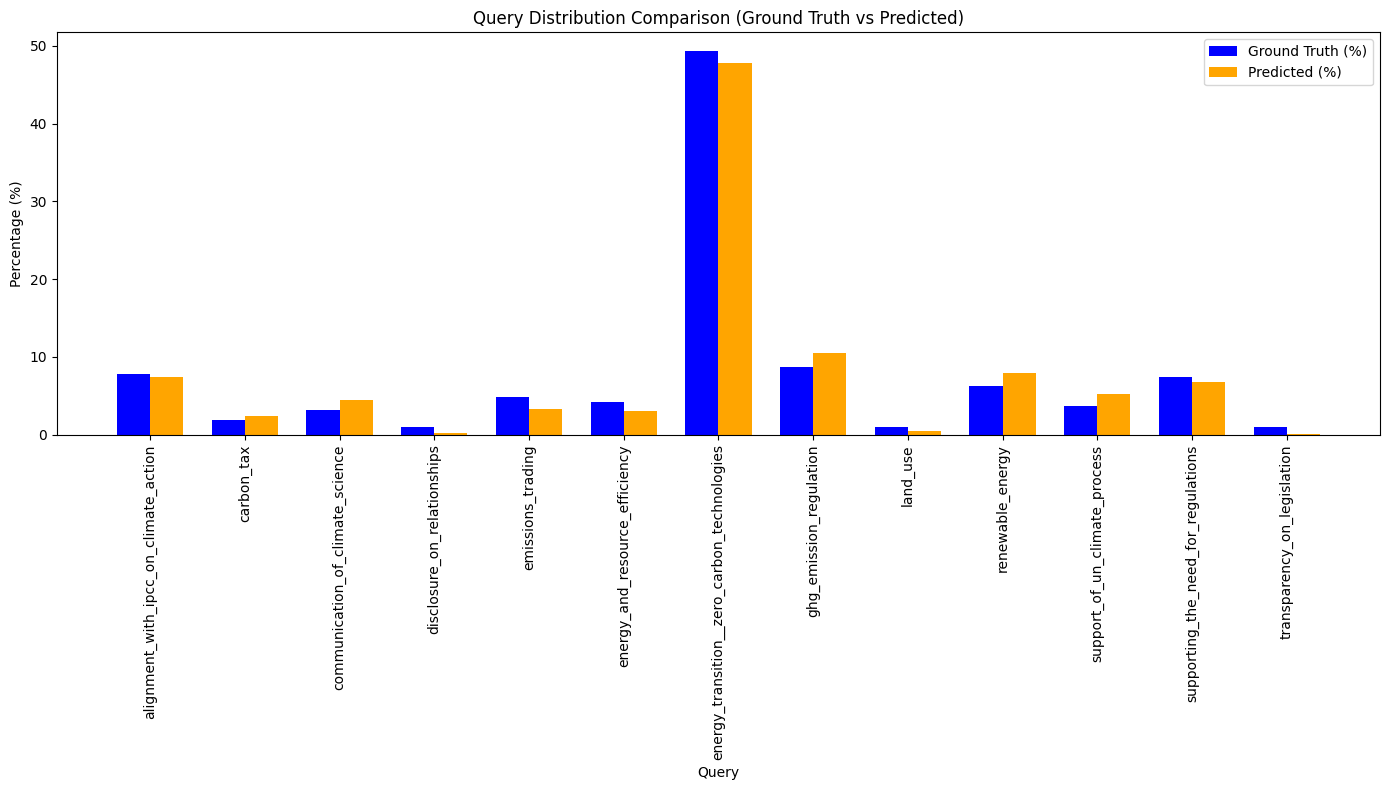

In [ ]:
# Function to compare the distribution by query, with label standardization
import matplotlib.pyplot as plt
import numpy as np

def compare_distribution_by_query(labeled_df, comparison_df):
    # Standardize the ground truth and predicted queries
    labeled_df['evidence_query_standardized'] = labeled_df['evidence_query'].apply(standardize_query_label)
    comparison_df['predicted_query_standardized'] = comparison_df['predicted_query'].apply(standardize_query_label)

    # Group the ground truth labeled data by standardized query
    ground_truth_dist = labeled_df['evidence_query_standardized'].value_counts(normalize=True) * 100  # Get percentage
    predicted_dist = comparison_df['predicted_query_standardized'].value_counts(normalize=True) * 100  # Get percentage

    # Combine the distributions into a DataFrame and align them
    dist_df = pd.DataFrame({
        'Ground Truth (%)': ground_truth_dist,
        'Predicted (%)': predicted_dist
    }).fillna(0)  # Fill NaN with 0 for missing categories

    # Set up for side-by-side bar plotting
    bar_width = 0.35
    index = np.arange(len(dist_df))

    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot ground truth bars
    ax.bar(index, dist_df['Ground Truth (%)'], bar_width, label='Ground Truth (%)', color='blue')

    # Plot predicted bars next to ground truth bars
    ax.bar(index + bar_width, dist_df['Predicted (%)'], bar_width, label='Predicted (%)', color='orange')

    # Add labels, title, and set x-ticks
    ax.set_xlabel('Query')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Query Distribution Comparison (Ground Truth vs Predicted)')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(dist_df.index, rotation=90)
    ax.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function to compare query distribution
compare_distribution_by_query(labeled_df, comparison_df)


## Inference on unlabelled data ##

In [ ]:
import random

# Function to perform inference on randomly selected unlabelled pages with a seed for reproducibility
def infer_on_unlabeled_data(non_labeled_df, num_pages=None, seed=42):
    # Set the random seed for reproducibility
    random.seed(seed)

    # If num_pages is None, select the entire dataset, otherwise randomly select the specified number of pages
    if num_pages:
        limited_df = non_labeled_df.sample(n=num_pages, random_state=seed)
    else:
        limited_df = non_labeled_df  # Select the whole dataset if num_pages is not specified

    predictions = []

    for index, row in limited_df.iterrows():
        page_text = row['evidence_extract_from_source']

        # Detect if the page contains evidence
        if detect_evidence(page_text):
            # Classify query for pages with evidence
            predicted_query, score = classify_page(page_text)
            predictions.append(predicted_query)

    return predictions

#Run inference on 100 randomly selected pages of non-labeled data
predicted_queries = infer_on_unlabeled_data(non_labeled_df)

# Count the predicted query distribution
predicted_query_distribution = pd.Series(predicted_queries).value_counts(normalize=True) * 100  # Convert to percentage

# Plot the distribution of predicted queries
plt.figure(figsize=(12, 6))
plt.bar(predicted_query_distribution.index, predicted_query_distribution.values, color='orange')
plt.xlabel('Query')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Predicted Queries for Unlabeled Data (100 Pages)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Initializing global attention on CLS token...
Input ids are automatically padded to be a multiple of `config.attention_window`: 512


NameError: name 'plt' is not defined

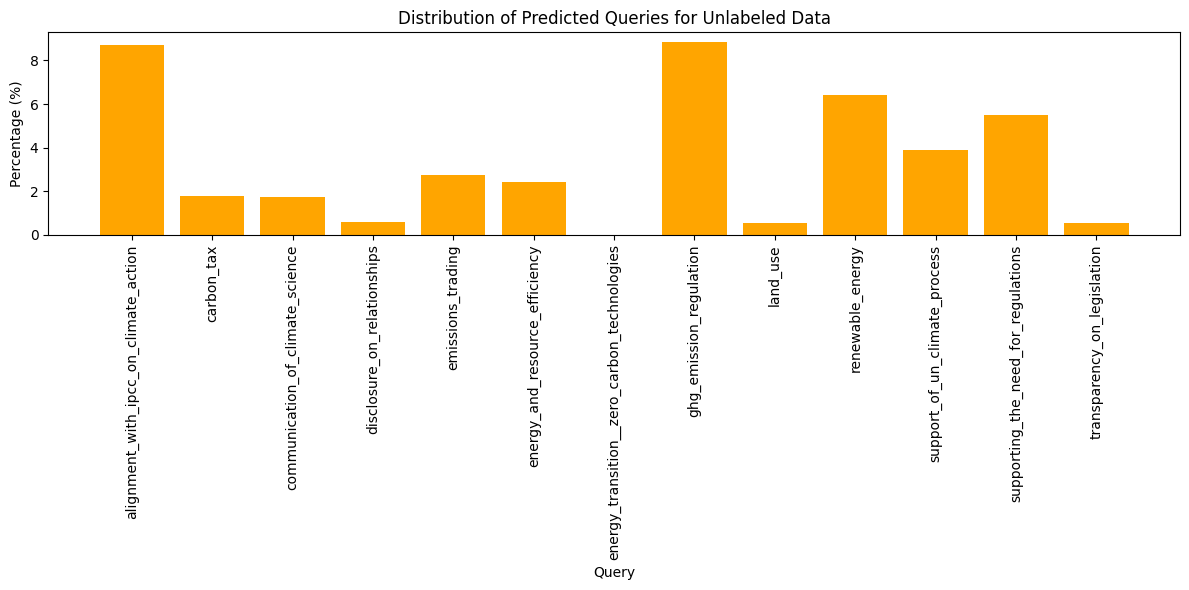

In [ ]:

import matplotlib.pyplot as plt  # Add this line to import matplotlib
import pandas as pd  # In case the data structures are from pandas

# Define the order of queries based on the previous graph
query_order = [
    "alignment_with_ipcc_on_climate_action", "carbon_tax", "communication_of_climate_science",
    "disclosure_on_relationships", "emissions_trading", "energy_and_resource_efficiency",
    "energy_transition__zero_carbon_technologies", "ghg_emission_regulation", "land_use",
    "renewable_energy", "support_of_un_climate_process", "supporting_the_need_for_regulations",
    "transparency_on_legislation"
]

# Ensure the predicted query distribution follows the same order
predicted_query_distribution_ordered = predicted_query_distribution.reindex(query_order, fill_value=0)

# Plot the distribution of predicted queries with the correct x-axis order
plt.figure(figsize=(12, 6))
plt.bar(predicted_query_distribution_ordered.index, predicted_query_distribution_ordered.values, color='orange')
plt.xlabel('Query')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Predicted Queries for Unlabeled Data')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
